## Compute LVEDVI, LVESVI, LVEF

- The use of the longer LV length between the apical two- and four-chamber views is recommended.
- LV volumes should be measured from the apical four- and two-chamber views.
- The most commonly used method for 2D echocardiographic volume calculations is the biplane method of disks summation (modified Simpson’s rule), which is the recommended 2D echocardiographic method by consensus of this committee
- Note: Two-dimensional echocardiographic image acquisition should aim to maximize LV areas, while avoiding foreshortening of the left ventricle, which results in volume underestimation

- Measurements and feature names:
    - LVEDVI - Left ventricle end diastolic volume index
    - LVESVI - Left ventricle end systolic volume index
    - LVEF - Left ventricle ejection fraction
        - LVEF = LVEDV – LVESV / LVEDV


- LV size and volume measurements should be reported indexed to BSA. For general reference, 2D echocardiographic 
    - LV EDVs of 74 mL/m<sup>2</sup> for men and 61 mL/m<sup>2</sup> for women
    - LV ESVs of 31 mL/m<sup>2</sup> for men and 24 mL/m<sup>2</sup> for women should be used as the upper limits of the corresponding normal range.
    


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy
from scipy.stats import mannwhitneyu
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import cohen_kappa_score

from utils import util_measurement, stats_and_plots, measurements_dict, BA_plot

In [2]:
def get_dataCat(df,feature1, value):
    """
    transform feature value in categorical
    Input: 
        - dataframe 
        - feature to be categorized. E.g., LAVI_echo_cat, LAV_echo, LAV_model LVMI_echo_cat, LVEF_echo, etc.
        - value to use as normal - Use 0 for RAVI, and RV, 35 for LVEF, normal for others
    """

    df_BA = df.copy()
    if feature1 == 'LVEF_echo':
        df_BA[feature1][df_BA[feature1] > value] = 'Normal' 
    else:
        df_BA[feature1][df_BA[feature1] == value] = 'Normal' 

    df_BA[feature1][df_BA[feature1] != 'Normal'] = 'Abnormal'
    return df_BA[feature1]

## Load Numbers table

In [3]:
### Load Clinical Echo Measurements

df_numbers = pd.read_csv('test_data/LV_volumetrics/LV_volumetrics.csv')
df_numbers.describe()

,BSA,LVEDVI_echo,LVESVI_echo,LVEF_echo
count,10.000000,10.000000,10.000000,10.000000
mean,1.824570,63.673197,30.264747,56.454418
std,0.167908,34.046478,27.995005,11.865648
min,1.497199,31.565623,13.422350,28.869076
25%,1.769761,48.526177,18.895364,51.606016
50%,1.854426,58.447846,20.657796,60.514791
75%,1.947333,64.083177,28.574820,61.829830
max,2.008035,154.902455,108.305279,70.647304


## Load dataframes with LV measurements - A2C, A4C views

In [4]:
df_a2c_allFrames = pd.read_csv('test_data/LV_volumetrics/A2C_measures_R2.csv')
df_a2c_allFrames.describe()

,RR,bbox-0,bbox-1,bbox-2,bbox-3,area,filled_area,convex_area,centroid-0,centroid-1,...,y_top,L_disk,Rsquared,RMSE,MSE,cycles,freq,amplitude,phase,offset
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,...,40.000000,40.000000,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0
mean,48.400000,106.050000,114.100000,188.125000,175.750000,21.228027,21.228027,23.117523,147.525000,143.300000,...,135.250000,0.294006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,29.923664,48.662601,17.327612,33.525488,17.454336,10.165321,10.165321,10.981048,39.246092,14.999487,...,20.941616,0.084911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,18.000000,36.000000,84.000000,128.000000,141.000000,4.144287,4.144287,4.632568,90.000000,121.000000,...,109.000000,0.105027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,30.000000,61.750000,101.750000,158.750000,161.750000,14.051819,14.051819,15.287781,109.750000,134.750000,...,120.000000,0.255521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,38.000000,98.500000,111.000000,192.000000,175.500000,19.506836,19.506836,21.884155,149.000000,140.500000,...,131.000000,0.299127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,49.000000,151.250000,120.250000,217.250000,189.500000,28.273010,28.273010,29.667664,182.250000,154.250000,...,148.000000,0.355268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,107.000000,194.000000,160.000000,245.000000,211.000000,51.684570,51.684570,57.342529,209.000000,178.000000,...,185.000000,0.439256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df_a4c_allFrames = pd.read_csv('test_data/LV_volumetrics/A4C_measures_R2.csv')
df_a4c_allFrames.describe()

,RR,bbox-0,bbox-1,bbox-2,bbox-3,area,filled_area,convex_area,centroid-0,centroid-1,...,y_top,L_disk,Rsquared,RMSE,MSE,cycles,freq,amplitude,phase,offset
count,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,...,79.000000,79.000000,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0
mean,42.886076,107.075949,87.405063,185.075949,137.417722,17.288478,17.288478,18.317346,147.506329,111.227848,...,109.037975,0.284297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,23.277031,47.784444,27.090787,32.994861,32.496393,7.672598,7.672598,8.040910,36.334935,27.850770,...,27.517101,0.085882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,16.000000,38.000000,32.000000,130.000000,86.000000,0.561523,0.561523,0.628662,94.000000,62.000000,...,56.000000,0.033275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,28.000000,61.000000,64.500000,153.500000,109.500000,12.481689,12.481689,13.226318,111.500000,85.500000,...,86.000000,0.236959,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,30.000000,102.000000,91.000000,194.000000,131.000000,16.436768,16.436768,18.066406,154.000000,122.000000,...,109.000000,0.296314,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,48.000000,149.000000,110.500000,214.000000,166.000000,21.228027,21.228027,22.198486,181.000000,136.500000,...,132.500000,0.348332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,94.000000,204.000000,138.000000,240.000000,193.000000,36.730957,36.730957,38.159180,208.000000,158.000000,...,164.000000,0.410594,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Apply qc rules

In [6]:
# Select the LV data
df_a2c_LV = df_a2c_allFrames[df_a2c_allFrames['label'] == 'LV']
df_a4c_LV = df_a4c_allFrames[df_a4c_allFrames['label'] == 'LV']

# Select the clip that has the best fit with the sinusoidal model
df_a2c_LV = df_a2c_LV.sort_values(by=['Rsquared'], ascending=False).drop_duplicates(subset=['anonid'])
df_a4c_LV = df_a4c_LV.sort_values(by=['Rsquared'], ascending=False).drop_duplicates(subset=['anonid'])

# Diastole clips take the largest LV area
df_a2c_dia = df_a2c_LV.sort_values(by='area', ascending=False).drop_duplicates('ID_clip')
df_a4c_dia = df_a4c_LV.sort_values(by='area', ascending=False).drop_duplicates('ID_clip')

# Systole clips take the smallest LV area
df_a2c_sys = df_a2c_LV.sort_values(by='area', ascending=True).drop_duplicates('ID_clip')
df_a4c_sys = df_a4c_LV.sort_values(by='area', ascending=True).drop_duplicates('ID_clip')

# Merge the dataframes
df_a2c = df_a2c_dia.merge(df_a2c_sys, on=['anonid', 'ID_clip'], suffixes=('_dia', '_sys')).drop_duplicates()
df_a4c = df_a4c_dia.merge(df_a4c_sys, on=['anonid', 'ID_clip'], suffixes=('_dia', '_sys')).drop_duplicates()

print('Final A2C frames:',df_a2c.shape[0], len(df_a2c.anonid.unique()))
print('Final A4C frames:',df_a4c.shape[0], len(df_a4c.anonid.unique()))

Final A2C frames: 10 10
Final A4C frames: 10 10


## Merge A2C and A4C IDs

In [7]:
# Merge the A2C and A4C dataframes
df_all = df_a2c.merge(df_a4c, on = ["anonid"],suffixes=("_a2c","_a4c"))

# Merge the clinical data
df_all = df_all.merge(df_numbers, on=['anonid'],how='left')

print(f'a2c size:{df_a2c.shape[0]}, a2c anonid:{len(df_a2c.anonid.unique())}, a4c size:{df_a4c.shape[0]}, anonid:{len(df_a4c.anonid.unique())}, merged:{df_all.shape[0]}, merged anonid:{len(df_all.anonid.unique())}')

a2c size:10, a2c anonid:10, a4c size:10, anonid:10, merged:10, merged anonid:10


## Compute LV volumetrics and function

In [8]:
df_vol = util_measurement.get_volumetrics(df_all, metric='LV_volumetrics')
print(df_vol.shape[0],len(df_vol.ID_clip_a2c.unique()),len(df_vol.ID_clip_a4c.unique()))

df_vol['LVEF_model'] = util_measurement.get_ef(df_vol.LVEDV_model.values, df_vol.LVESV_model.values)
print('LVEF:', df_vol.shape[0])

  0%|          | 0/10 [00:00<?, ?it/s]/home/ec2-user/miniconda3/envs/ssl-seg/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
100%|██████████| 10/10 [00:00<00:00, 838.04it/s]

10 10 10
LVEF: 10


## Bin LV vol in normal and abnormal

In [9]:
# Filter out the patients with no sex information
df_vol = df_vol[(df_vol['Pt. Sex'] == 'F') | (df_vol['Pt. Sex'] == 'M')]

## Cat values for Model Pred
df_vol['LVEDVI_model_cat'] = df_vol['LVEDVI_model'].astype(int)
df_vol['LVEDVI_model_cat'] = np.where((df_vol['Pt. Sex'] == 'M'), df_vol['LVEDVI_model_cat'].apply(lambda x: measurements_dict.get_severity(x, measurements_dict.lvedvi_echo_male_dict)), df_vol['LVEDVI_model_cat'])
df_vol['LVEDVI_model_cat'] = np.where((df_vol['Pt. Sex'] == 'F'), df_vol['LVEDVI_model_cat'].apply(lambda x: measurements_dict.get_severity(x, measurements_dict.lvedvi_echo_female_dict)), df_vol['LVEDVI_model_cat'])

## Cat values for Numbers table 
df_vol['LVEDVI_echo_cat'] = df_vol['LVEDVI_echo'].astype(int)
df_vol['LVEDVI_echo_cat'] = np.where((df_vol['Pt. Sex'] == 'M'), df_vol['LVEDVI_echo_cat'].apply(lambda x: measurements_dict.get_severity(x, measurements_dict.lvedvi_echo_male_dict)), df_vol['LVEDVI_echo_cat'])
df_vol['LVEDVI_echo_cat'] = np.where((df_vol['Pt. Sex'] == 'F'), df_vol['LVEDVI_echo_cat'].apply(lambda x: measurements_dict.get_severity(x, measurements_dict.lvedvi_echo_female_dict)), df_vol['LVEDVI_echo_cat'])
df_vol = df_vol[(df_vol['Pt. Sex'] == 'F') | (df_vol['Pt. Sex'] == 'M')]

## Cat values for Model Pred

df_vol['LVESVI_model_cat'] = df_vol['LVESVI_model'].astype(int)
df_vol['LVESVI_model_cat'] = np.where((df_vol['Pt. Sex'] == 'M'), df_vol['LVESVI_model_cat'].apply(lambda x: measurements_dict.get_severity(x, measurements_dict.lvesvi_echo_male_dict)), df_vol['LVESVI_model_cat'])
df_vol['LVESVI_model_cat'] = np.where((df_vol['Pt. Sex'] == 'F'), df_vol['LVESVI_model_cat'].apply(lambda x: measurements_dict.get_severity(x, measurements_dict.lvesvi_echo_female_dict)), df_vol['LVESVI_model_cat'])

## Cat values for Numbers table (qplus)
df_vol['LVESVI_echo_cat'] = df_vol['LVESVI_echo'].astype(int)
df_vol['LVESVI_echo_cat'] = np.where((df_vol['Pt. Sex'] == 'M'), df_vol['LVESVI_echo_cat'].apply(lambda x: measurements_dict.get_severity(x, measurements_dict.lvesvi_echo_male_dict)), df_vol['LVESVI_echo_cat'])
df_vol['LVESVI_echo_cat'] = np.where((df_vol['Pt. Sex'] == 'F'), df_vol['LVESVI_echo_cat'].apply(lambda x: measurements_dict.get_severity(x, measurements_dict.lvesvi_echo_female_dict)), df_vol['LVESVI_echo_cat'])

## Compute and plot some metrics

Volume - Left Ventricle 
(10, 161)


,LVEF_model,LVEF_echo,LVEDVI_model,LVEDVI_echo,LVESVI_model,LVESVI_echo
mean,54.445794,56.454418,54.329519,63.673197,25.910109,30.264747
std,11.613895,11.865648,15.851020,34.046478,14.755329,27.995005
min,30.892851,28.869076,34.680369,31.565623,14.668689,13.422350
max,68.479300,70.647304,91.690672,154.902455,63.364809,108.305279


LVEF echo-model - p-value (MWU): 0.3115881119410587

LVEDVI echo-model - p-value (MWU): 0.21367765694890384

LVESVI echo-model - p-value (MWU): 0.45486094457277765


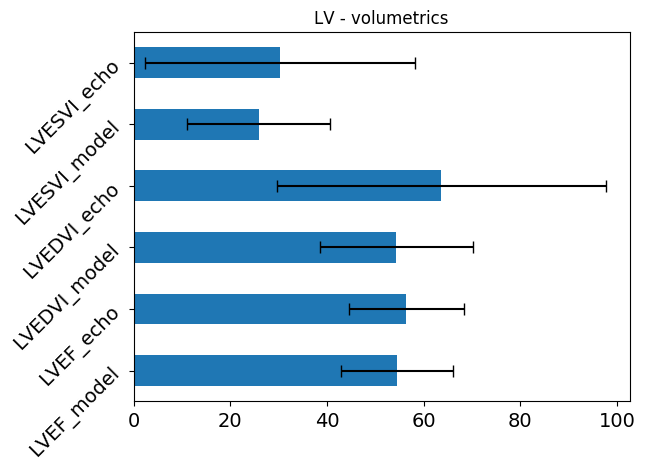

In [10]:
## Mean, std and range of volume.
print('Volume - Left Ventricle ')
print(df_vol.shape)
df_vol_stats  = df_vol[['LVEF_model','LVEF_echo','LVEDVI_model', 'LVEDVI_echo', 'LVESVI_model', 'LVESVI_echo']].agg(['mean','std','min', 'max'])
display(df_vol_stats)

H, p = mannwhitneyu(df_vol['LVEF_echo'].dropna().values, df_vol['LVEF_model'].dropna().values)
print('LVEF echo-model - p-value (MWU):',p)
print()

H, p = mannwhitneyu(df_vol['LVEDVI_echo'].dropna().values, df_vol['LVEDVI_model'].dropna().values)
print('LVEDVI echo-model - p-value (MWU):',p)
print()

H, p = mannwhitneyu(df_vol['LVESVI_echo'].dropna().values, df_vol['LVESVI_model'].dropna().values)
print('LVESVI echo-model - p-value (MWU):',p)


df_vol_stats.T.plot(kind = "barh", y = ["mean"], legend = False,
            title = 'LV - volumetrics',fontsize=14,  xerr='std', capsize=4,rot=45)
plt.show()

## Regression and Bland-Altman Plots


10 10


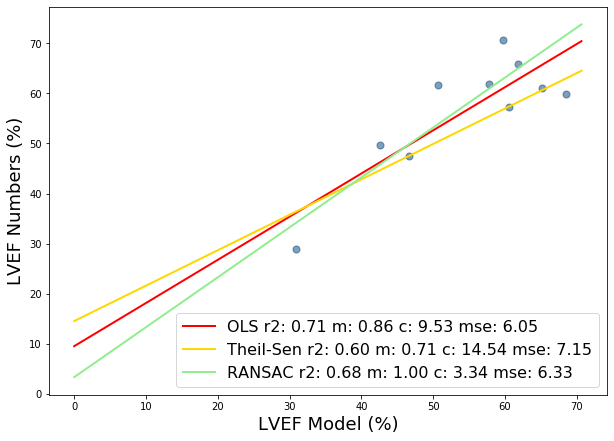

/home/ec2-user/miniconda3/envs/ssl-seg/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == "":


['Normal', 'Abnormal']
['Abnormal' 'Normal']


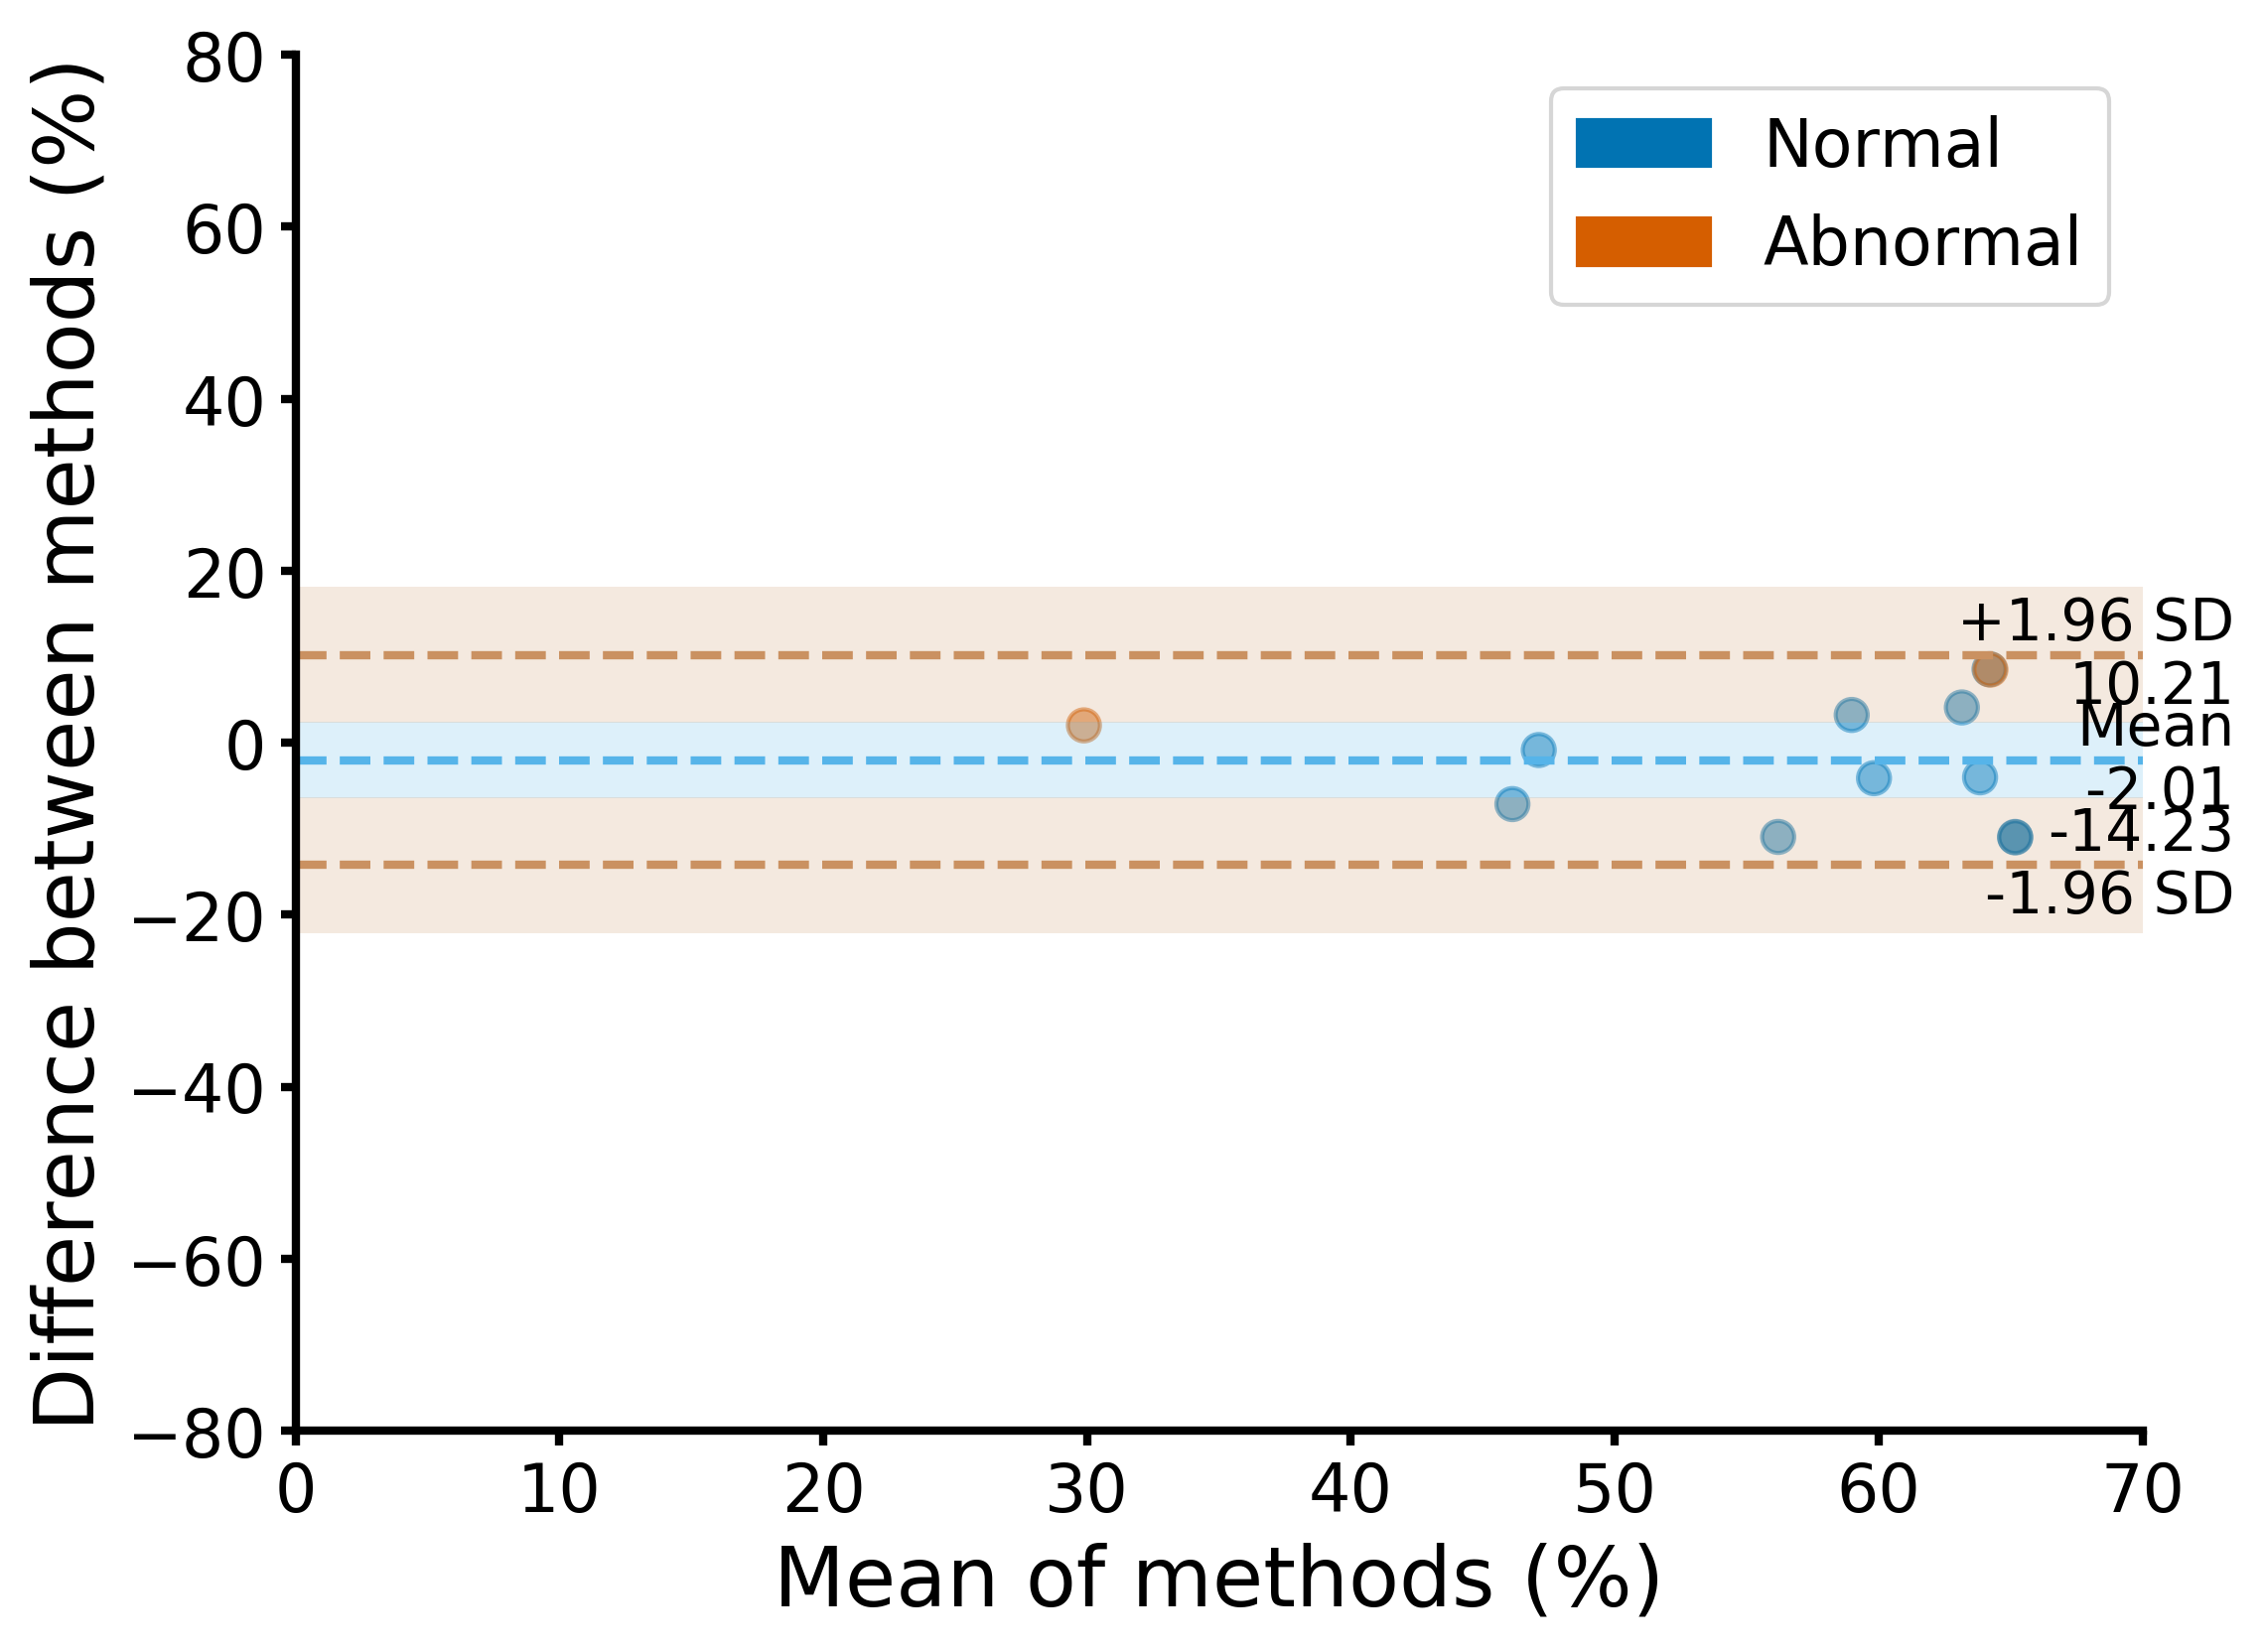

SpearmanrResult(correlation=0.5151515151515151, pvalue=0.12755286970323426)
MWU p-value: MannwhitneyuResult(statistic=43.0, pvalue=0.3115881119410587)
10


/home/ec2-user/miniconda3/envs/ssl-seg/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


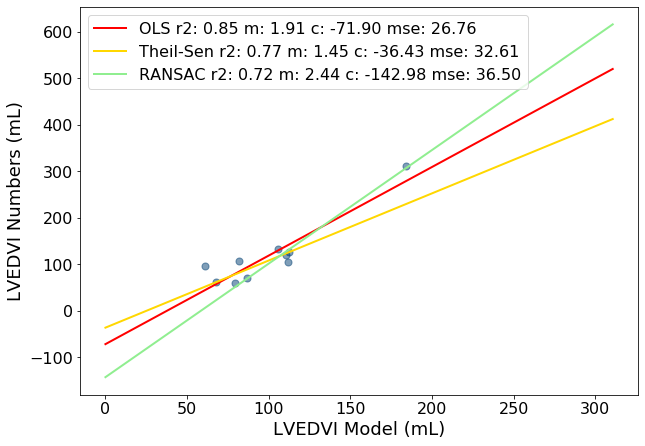

['Normal', 'Abnormal']
['Abnormal' 'Normal']


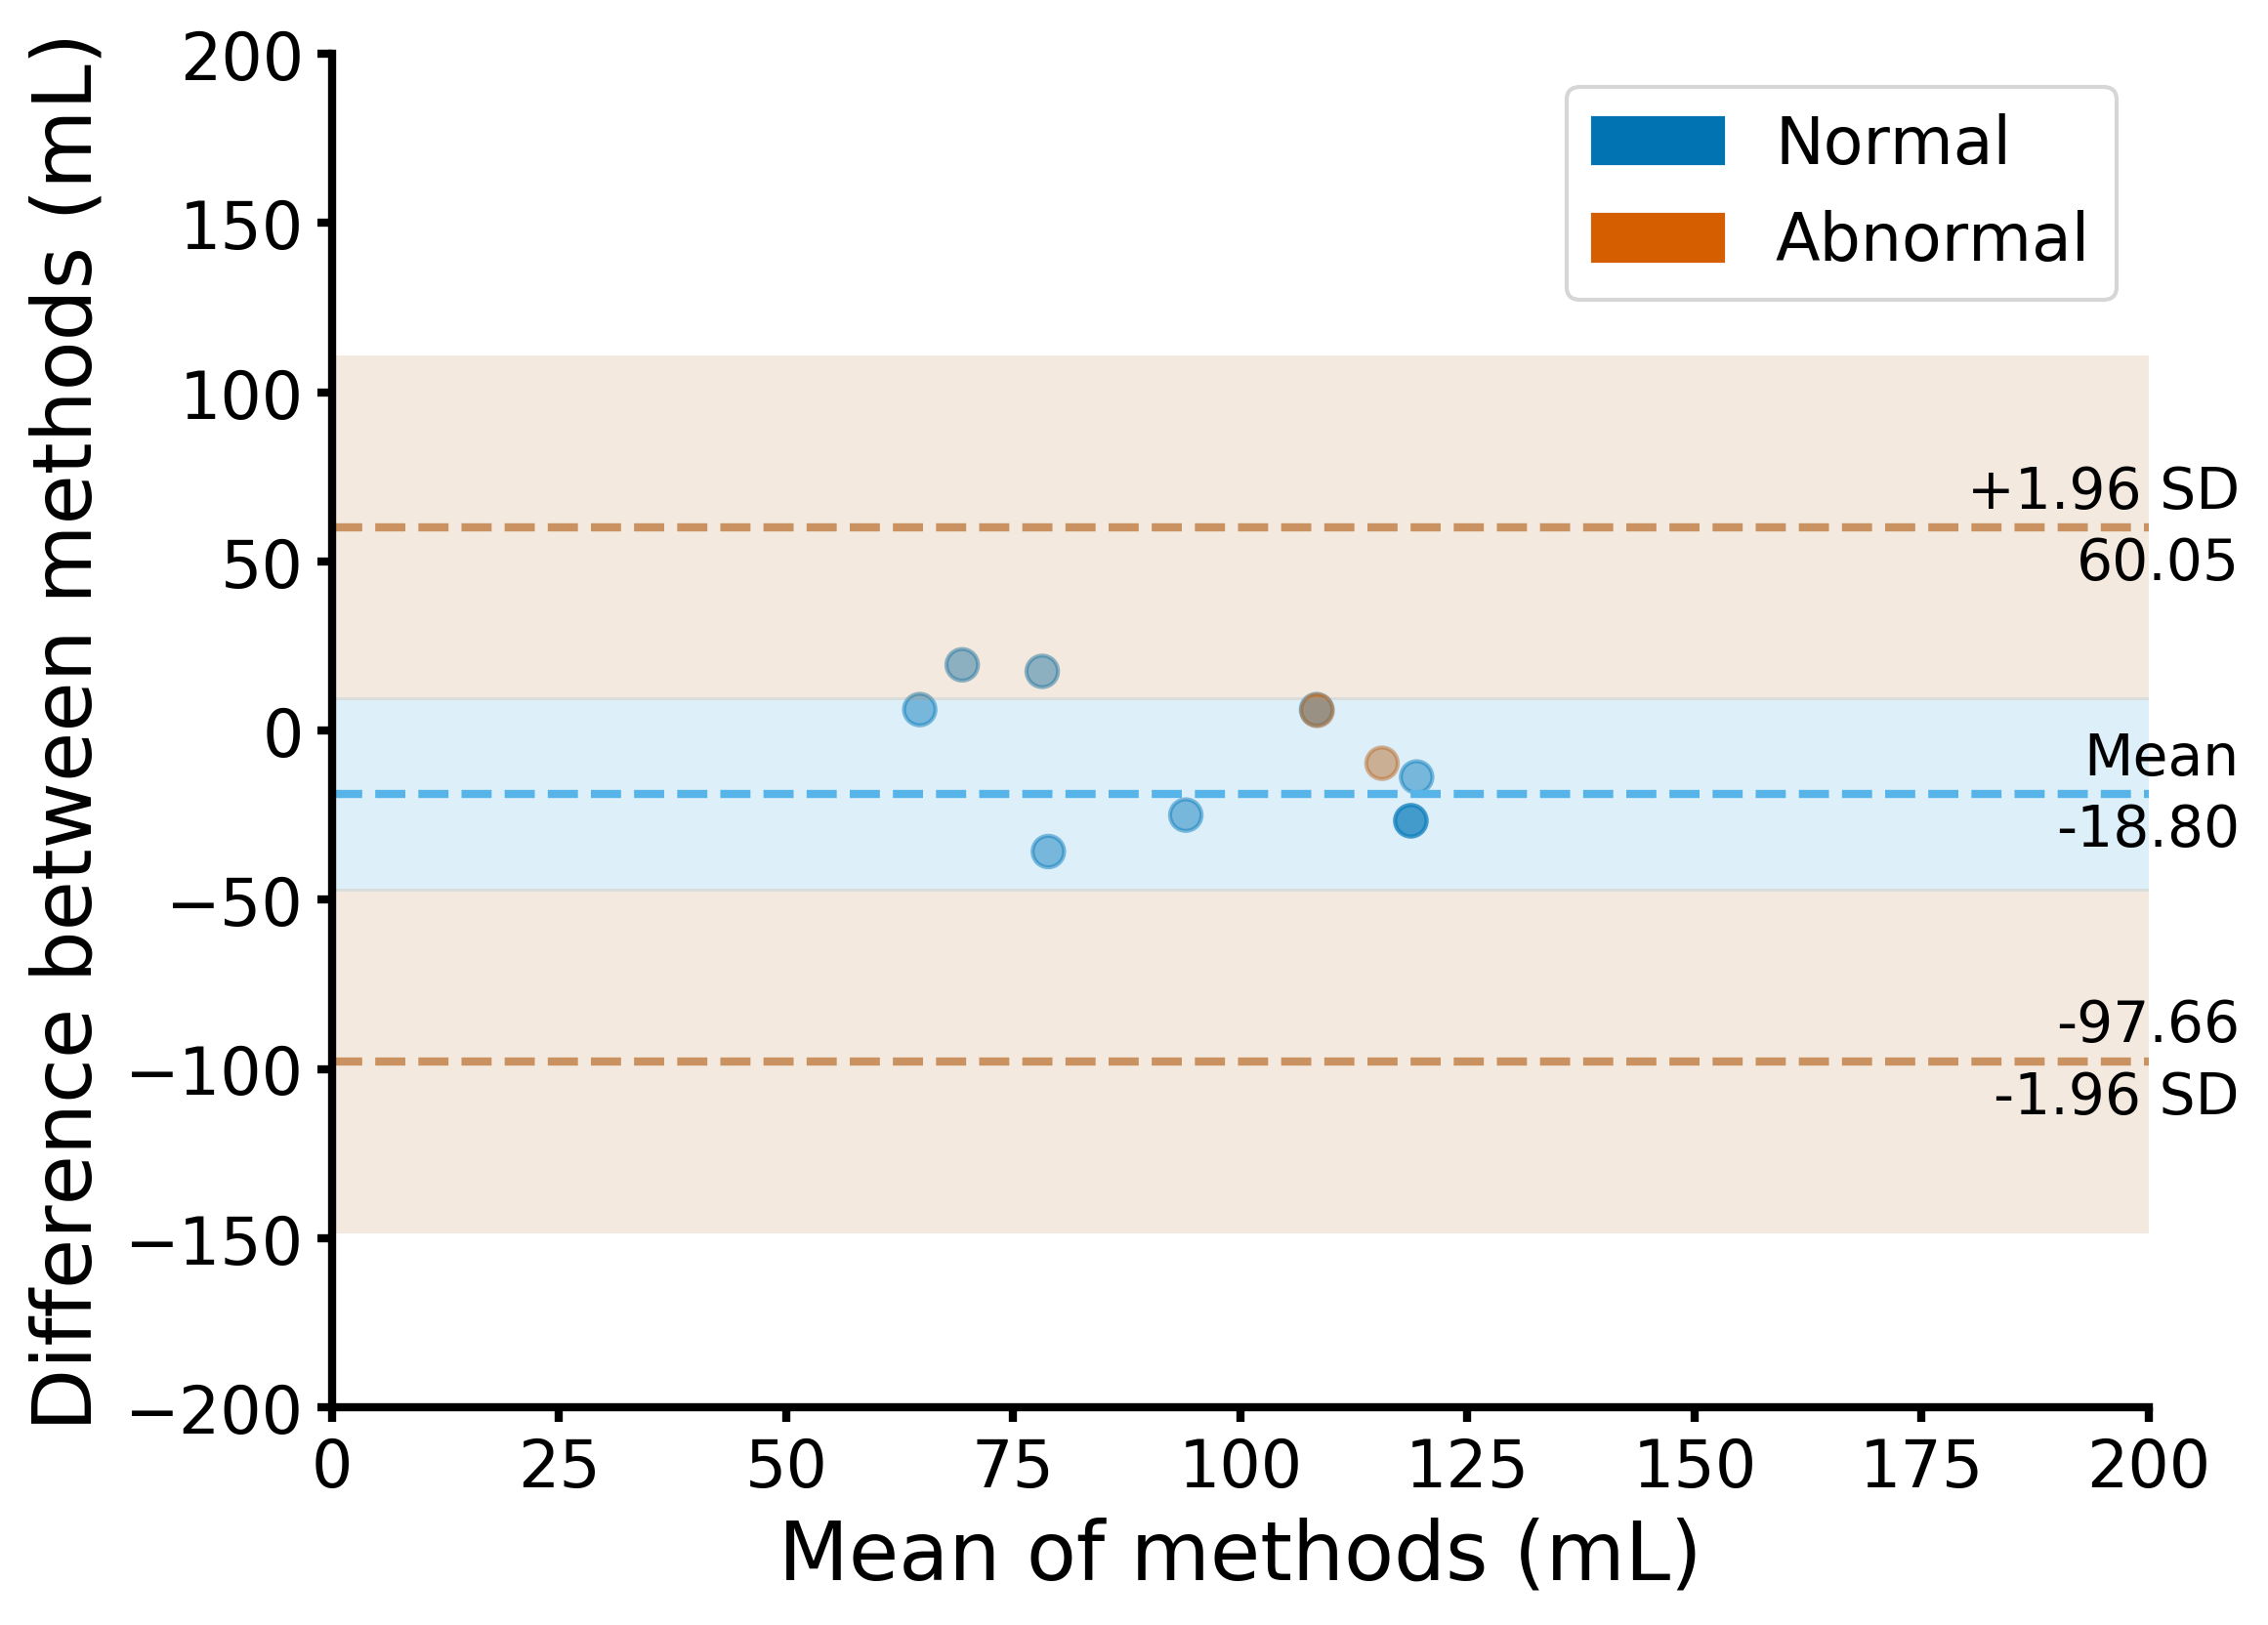

SpearmanrResult(correlation=0.7575757575757575, pvalue=0.011143446799694208)
MWU p-value: MannwhitneyuResult(statistic=44.0, pvalue=0.33879247897623777)
10


/home/ec2-user/miniconda3/envs/ssl-seg/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


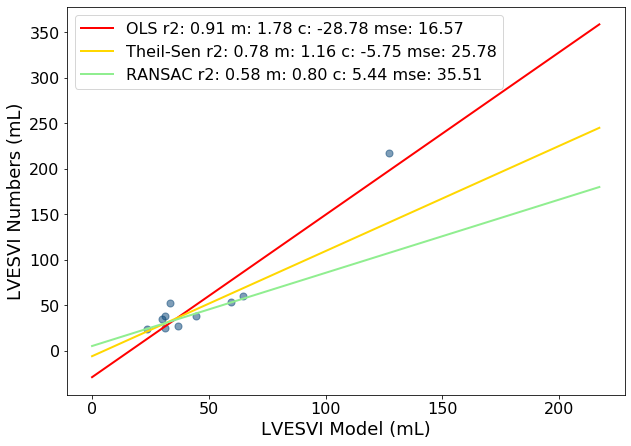

['Normal', 'Abnormal']
['Abnormal' 'Normal']


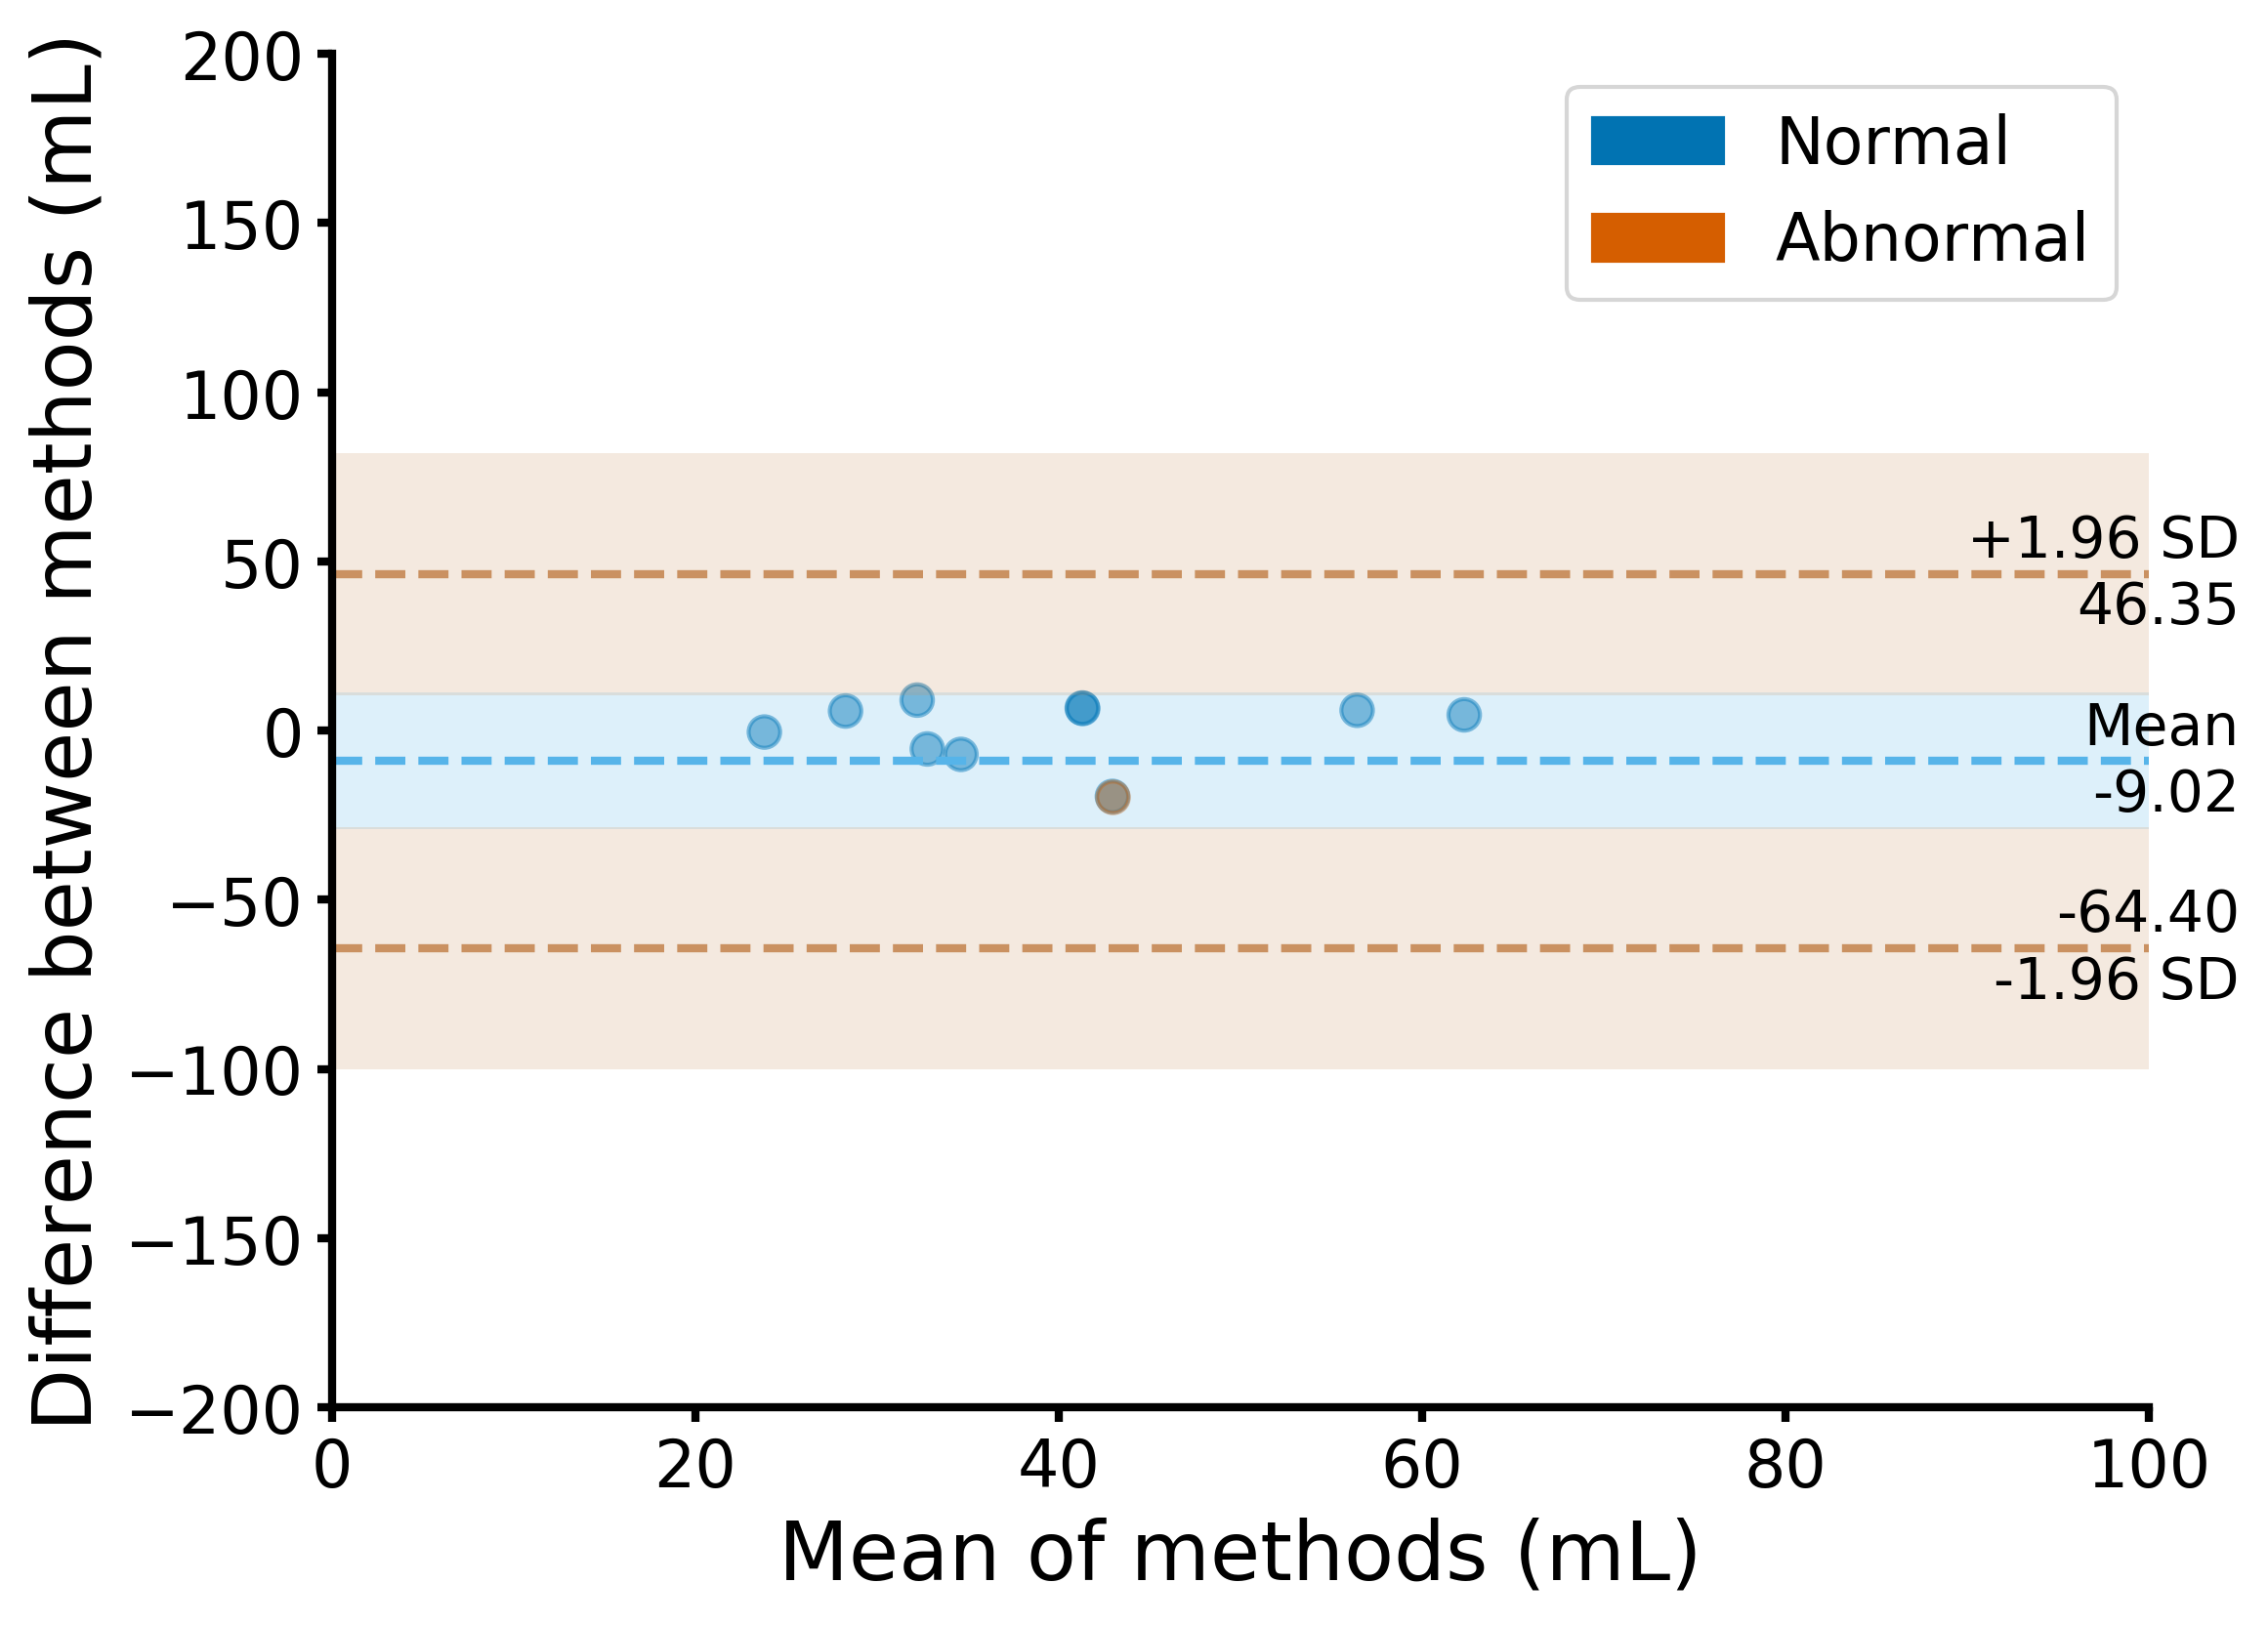

SpearmanrResult(correlation=0.7939393939393938, pvalue=0.0060999233136969115)
MWU p-value: MannwhitneyuResult(statistic=48.0, pvalue=0.45486094457277765)


/home/ec2-user/miniconda3/envs/ssl-seg/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


In [11]:
############### LVEF ##################

df_plot = df_vol
    
ys = df_plot['LVEF_echo'] 
xs = df_plot['LVEF_model']
print(len(xs),len(ys))

stats_and_plots.get_reg_plot(xs, ys, 'Numbers-Model', 'LVEF Model', 'LVEF Numbers', '%')

dataCat = get_dataCat(df_plot, 'LVEF_echo', 35) 

# measurement units - ## 'mL/m$^2$' cm$^2$/m$^2$
BA_plot.blandAltman(xs, ys,dataCat,percentage=False, figureSize=((8,6)),meanColour='#56b4e9', dpi = 300,
            loaColour='#ca9161', pointColour='#0173b2',lim_inf=-80, lim_sup=80, cat=True, unity='%')#,savePath='../final_results/plots/BA_LAV_zs.png')

plt.show()
print(scipy.stats.spearmanr(xs,ys))
scipy.stats.normaltest(xs-ys) # (if P < 0.05 then reject normality).
print('MWU p-value:',mannwhitneyu(xs,ys))

############ LVEDVI ##################

ys = df_plot['LVEDVI_echo'] * df_plot['BSA']
xs = df_plot['LVEDVI_model'] * df_plot['BSA']
print(len(xs))
stats_and_plots.get_reg_plot(xs,ys,'Numbers-Model','LVEDVI Model','LVEDVI Numbers','mL')

dataCat = df_plot.LVEDVI_echo_cat
BA_plot.blandAltman(xs, ys,dataCat,percentage=False, figureSize=((8,6)),meanColour='#56b4e9', dpi = 300,
            loaColour='#ca9161', pointColour='#0173b2',lim_inf=-200, lim_sup=200, lim_inf_x=0, lim_sup_x=200, cat=True, unity='mL')#,savePath='../final_results/plots/BA_LAV_zs.png')

plt.show()
print(scipy.stats.spearmanr(xs,ys))
scipy.stats.normaltest(xs-ys) # (if P < 0.05 then reject normality).
print('MWU p-value:',mannwhitneyu(xs,ys))

############ LVESVI ##################

ys = df_plot['LVESVI_echo'] * df_plot['BSA']
xs = df_plot['LVESVI_model'] * df_plot['BSA']
print(len(xs))
stats_and_plots.get_reg_plot(xs,ys,'Numbers-Model','LVESVI Model', 'LVESVI Numbers','mL')
dataCat = df_plot.LVESVI_echo_cat
BA_plot.blandAltman(xs, ys,dataCat,percentage=False, figureSize=((8,6)),meanColour='#56b4e9', dpi = 300,
            loaColour='#ca9161', pointColour='#0173b2',lim_inf=-200, lim_sup=200, lim_inf_x=0, lim_sup_x=100, cat=True, unity='mL')#,savePath='../final_results/plots/BA_LAV_zs.png')

plt.show()
print(scipy.stats.spearmanr(xs,ys))
scipy.stats.normaltest(xs-ys) # (if P < 0.05 then reject normality).
print('MWU p-value:',mannwhitneyu(xs,ys))

## Plot Confusion Matrix

Confusion Matrix - Numbers vs Unet


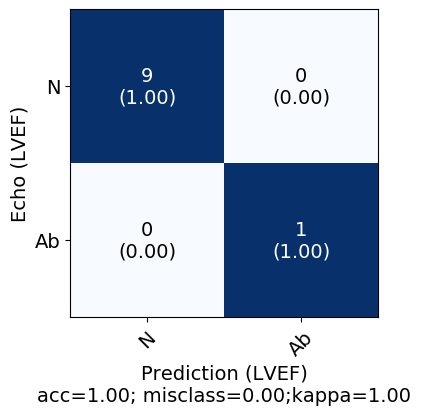

Confusion Matrix - Numbers vs Unet


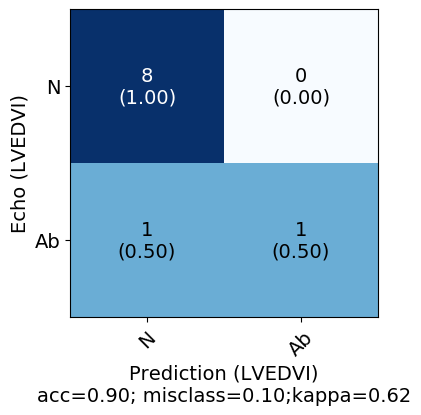

Confusion Matrix - Numbers vs Unet


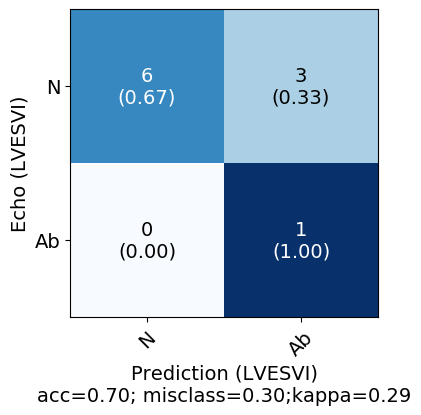

In [12]:
############### LVEF ##################

plt.rcParams.update({'font.size': 14})

y_true = df_vol['LVEF_echo'] <= 35
y_pred = df_vol['LVEF_model'] <= 35

cm = confusion_matrix(y_true, y_pred) #.ravel()

accuracy = np.trace(cm) / np.sum(cm).astype('float')   ## total samples that were correctly classified
misclass = 1 - accuracy
k = cohen_kappa_score(y_true.astype(int), y_pred.astype(int))

plot_confusion_matrix(conf_mat=cm,colorbar=False,
                                show_absolute=True,
                                show_normed=True,
                                class_names=['N','Ab'],
                                figsize=(4, 4))
plt.ylabel('Echo (LVEF)')
plt.xlabel('Prediction (LVEF)\nacc={:0.2f}; misclass={:0.2f};kappa={:0.2f}'.format(accuracy, misclass,k))
print('Confusion Matrix - Numbers vs Unet')
plt.show()

############### LVEDVI ##################

plt.rcParams.update({'font.size': 14})


y_true = df_vol['LVEDVI_echo_cat'] == 'Abnormal'
y_pred = df_vol['LVEDVI_model_cat'] == 'Abnormal'

cm = confusion_matrix(y_true, y_pred) #.ravel()

accuracy = np.trace(cm) / np.sum(cm).astype('float')   ## total samples that were correctly classified
misclass = 1 - accuracy
k = cohen_kappa_score(y_true.astype(int), y_pred.astype(int))

plot_confusion_matrix(conf_mat=cm,colorbar=False,
                                show_absolute=True,
                                show_normed=True,
                                class_names=['N','Ab'],
                                figsize=(4, 4))
plt.ylabel('Echo (LVEDVI)')
plt.xlabel('Prediction (LVEDVI)\nacc={:0.2f}; misclass={:0.2f};kappa={:0.2f}'.format(accuracy, misclass,k))
print('Confusion Matrix - Numbers vs Unet')
plt.show()

############### LVESVI ##################

plt.rcParams.update({'font.size': 14})


y_true = df_vol['LVESVI_echo_cat'] == 'Abnormal'
y_pred = df_vol['LVESVI_model_cat'] == 'Abnormal'

cm = confusion_matrix(y_true, y_pred)

accuracy = np.trace(cm) / np.sum(cm).astype('float')   ## total samples that were correctly classified
misclass = 1 - accuracy
k = cohen_kappa_score(y_true.astype(int), y_pred.astype(int))

plot_confusion_matrix(conf_mat=cm,colorbar=False,
                                show_absolute=True,
                                show_normed=True,
                                class_names=['N','Ab'],
                                figsize=(4, 4))
plt.ylabel('Echo (LVESVI)')
plt.xlabel('Prediction (LVESVI)\nacc={:0.2f}; misclass={:0.2f};kappa={:0.2f}'.format(accuracy, misclass,k))
print('Confusion Matrix - Numbers vs Unet')
plt.show()